<a href="https://colab.research.google.com/github/2023aixDeepLearning/aix_deeplearning/blob/%EC%9C%A4%EC%98%81/AIX_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

필요한 모듈을 import 한다.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from cvxopt import matrix
from scipy.optimize import minimize
from keras.models import Sequential
from keras.layers import GRU, Dense
from IPython.display import clear_output

# Datasets
FinanceDataReader 모듈을 통해 코스피에 상장된 주식 데이터를 가져온다.

In [2]:
!pip install -U finance-datareader
import FinanceDataReader as fdr

In [3]:
stock_name = fdr.StockListing('KOSPI')['Name'].to_list()
stock_code = fdr.StockListing('KOSPI')['Code'].to_list()

print(stock_name[0:20])
print(stock_code[0:20])

['삼성전자', 'LG에너지솔루션', 'SK하이닉스', '삼성바이오로직스', '삼성전자우', 'POSCO홀딩스', '현대차', '기아', 'LG화학', 'NAVER', '삼성SDI', '포스코퓨처엠', '셀트리온', '카카오', '삼성물산', '현대모비스', 'KB금융', '신한지주', 'LG전자', '삼성생명']
['005930', '373220', '000660', '207940', '005935', '005490', '005380', '000270', '051910', '035420', '006400', '003670', '068270', '035720', '028260', '012330', '105560', '055550', '066570', '032830']


코스피 주식 중 2000년 이전에 상장된 주요 주식들을 선정하였다.

In [ ]:
my_portfolio = ['삼성전자', 'SK하이닉스','POSCO홀딩스', '현대차', '기아', '삼성SDI', '현대모비스', 'LG', '카카오', 'SK텔레콤', '기업은행', 'S-Oil', 'KT']
len(my_portfolio)

13

주식의 종가를 바탕으로 포트폴리오 투자를 진행하기 위해 각 주식의 2000년 이후의 종가 데이터를 가져온다.

In [ ]:
stock_dict = dict(zip(stock_name, stock_code))

stock_df = pd.DataFrame()

for stock in my_portfolio:
    stock_df[stock] = fdr.DataReader(stock_dict[stock], '2000-01-01', '2023-01-01')['Close']


stock_df

,삼성전자,SK하이닉스,POSCO홀딩스,현대차,기아,삼성SDI,현대모비스,LG,카카오,SK텔레콤,기업은행,S-Oil,KT
Date,,,,,,,,,,,,,
2000-01-04,6110,505462,142000,20700,7350,50400,6610,47025,30383,65564,5100,12725,169000
2000-01-05,5580,453444,149500,20800,6950,47500,7100,44328,26769,55729,4950,11300,145500
2000-01-06,5620,429888,144500,19700,6650,43000,6540,41631,23556,56713,4800,10500,147500
2000-01-07,5540,425962,145000,20300,6500,41000,6520,44562,20746,57972,4950,11350,133000
2000-01-10,5770,422037,143000,20000,6800,41600,6280,46908,20969,63838,5450,11875,145000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,58100,77800,288500,157000,62700,622000,206500,82100,53400,49000,11100,88000,35800
2022-12-26,57900,77000,292000,158000,63700,624000,209500,81400,53600,49250,11050,89500,36000
2022-12-27,58100,77000,292000,158000,64100,624000,210000,81900,54400,49300,11200,89100,36300


10 영업일 주기로 포트폴리오 리밸런싱할 것을 고려하여, 10 영업일 주기의 데이터를 가져온다. 영업일은 주말과 휴일을 제외한 기간으로 매수, 매도가 가능한 기간이다. 10 영업일은 약 2주이다.

In [ ]:
df = stock_df.iloc[::10,:]
df

,삼성전자,SK하이닉스,POSCO홀딩스,현대차,기아,삼성SDI,현대모비스,LG,카카오,SK텔레콤,기업은행,S-Oil,KT
Date,,,,,,,,,,,,,
2000-01-04,6110,505462,142000,20700,7350,50400,6610,47025,30383,65564,5100,12725,169000
2000-01-18,6100,490740,145500,17800,7800,44300,6000,51188,26100,66426,5380,10500,139500
2000-02-01,5320,480925,129500,17000,6690,45700,6100,45852,24270,63235,5000,9750,124000
2000-02-16,5000,410259,100000,14000,6280,41550,5150,42217,43455,72465,4070,9950,123000
2000-03-02,5880,403388,110500,13200,4470,36150,4245,37174,32034,81955,3750,9225,107500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,57700,93500,239500,162500,66300,655000,199000,77300,48800,49550,10150,82200,36000
2022-11-08,61800,87700,273000,170000,67500,730000,217500,81800,51500,50500,10500,93900,36500
2022-11-22,60600,85200,292500,165500,65200,680000,210500,83600,54300,49750,11000,86900,36850


In [ ]:
def get_returns(result):
  ans = [0]
  for i in range(1, len(result)):
    ans.append((result[i]-result[i-1])/result[i-1])
  return ans
def get_mean_return(returns):
  return sum(returns)/len(returns)
def get_risk(returns):
  n = len(returns)
  mean = sum(returns)/n
  ans = 0
  for i in range(n):
    ans += (returns[i]-mean)**2
  return (ans/n)**(1/2)



In [ ]:
mean_return_of_each_asset = []
risk_of_each_asset = []

for i in my_portfolio:

  ret = get_returns(list(df[i]))
  mean_return_of_each_asset.append(get_mean_return(ret))
  risk_of_each_asset.append(get_risk(ret))


각 종목 별 총 기간의 평균 수익과 변동성을 확인한다.

In [ ]:
pd.DataFrame({'mean_returns':mean_return_of_each_asset, 'Volatility':risk_of_each_asset},index=my_portfolio)

,mean_returns,Volatility
삼성전자,0.006299,0.067775
SK하이닉스,0.004427,0.122544
POSCO홀딩스,0.003825,0.072030
현대차,0.006641,0.077971
기아,0.007118,0.081443
삼성SDI,0.007888,0.082997
현대모비스,0.009202,0.080623
LG,0.004723,0.086994
카카오,0.007889,0.125370
SK텔레콤,0.001227,0.058748


#Methodology

시계열 예측을 위한 예시 데이터 생성. 0 시점부터 199시점까지의 데이터를 가진다.

Example data


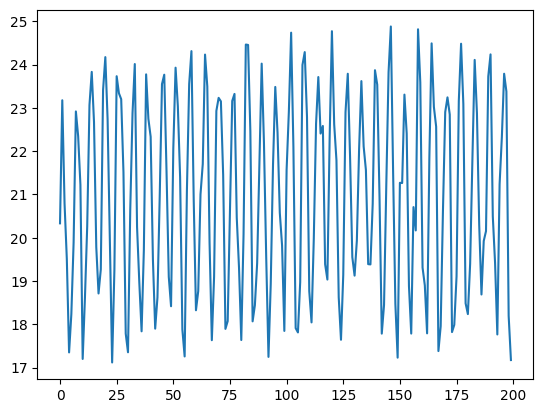

In [ ]:
import random
random.seed(123)

time_series_data = []
for i in range(200):
  time_series_data.append(3*np.sin(i + random.random())+20+2*random.random())

print('Example data')
plt.plot(time_series_data)

ARIMA 모델을 통한 시계열 예측

처음 시점부터 t 시점까지의 데이터를 이용해 t+1 시점의 값을 예측하는 과정을 반복한다. 이렇게 180시점부터 199시점 까지의 값을 예측한다.

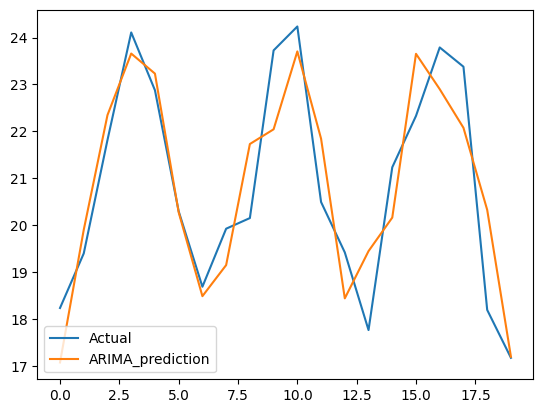

In [ ]:
order = (2,1,2)

ARIMA_preds = []
for i in range(180,200):
  model = ARIMA(time_series_data[0:i], order=order)
  res = model.fit()
  prediction = res.forecast(steps=1)
  ARIMA_preds.append(prediction)

plt.plot(time_series_data[180:], label = 'Actual')
plt.plot(ARIMA_preds, label = 'ARIMA_prediction')
plt.legend()
plt.show()

같은 데이터를 활용하여 XGBoost를 통한 예측

t, t-1, ..., t-4 시점까지의 값을 X_train의 각각의 feature로 지정하고, t+1 시점의 값을 y로 지정하여 예측한다.

In [ ]:
def create_sequence(data, seq_length):
  sequence = [data[i:i+seq_length+1] for i in range(len(data)-seq_length+1+1)]

  df = pd.DataFrame(sequence)

  return df.dropna()


def XGB_AutoRgression(data, seq_length, XGB_params):
    seq_df = pd.DataFrame(create_sequence(data, seq_length))

    X_train = seq_df.iloc[:-1,1:]
    y_train = seq_df.iloc[:-1,0]
    X_test = seq_df.iloc[-1:,1:]

    model = xgb.XGBRegressor(**XGB_params)
    model.fit(X_train, y_train)
    pred_y = model.predict(X_test)
    return pred_y

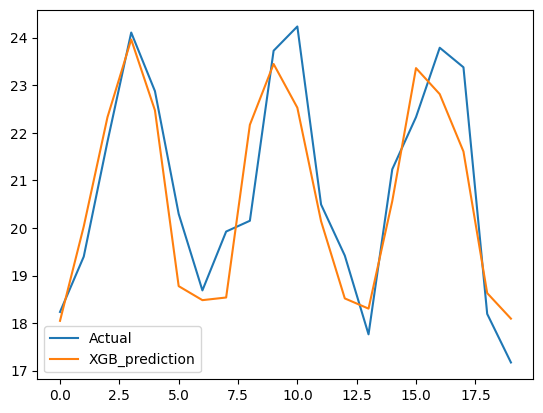

In [ ]:
XGB_parameters = {
    'n_estimators': 30,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0,
    'reg_lambda': 1}

XGB_preds = []
for i in range(180,200):
  XGB_preds.append(XGB_AutoRgression(time_series_data[:i], 5, XGB_parameters))

plt.plot(time_series_data[180:], label = 'Actual')
plt.plot(XGB_preds, label = 'XGB_prediction')
plt.legend()
plt.show()

GRU를 통한 시계열 예측 예시

GRU_model을 구축한다.

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense

GRU_model = Sequential()
GRU_model.add(GRU(8, input_shape=(5, 1)))
GRU_model.add(Dense(10))
GRU_model.add(Dense(1))
GRU_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])


sequence를 생성하고 `GRU_model`에 적합시킨다.

In [ ]:
def create_sequence_for_GRU(data, seq_length):
  sequences = []
  for i in range(len(data) - seq_length):
      seq = data[i:i + seq_length]
      target = data[i+seq_length : i+seq_length+1]
      sequences.append((seq, target))
  return np.array(sequences)


def GRU(data, seq_length, GRU_model):

  sequences = create_sequence_for_GRU(data, seq_length)

  train_sequences = sequences[:-1]
  test_sequences = sequences[-1:]

  X_train = np.array([item[0] for item in train_sequences])
  y_train = np.array([item[1] for item in train_sequences])
  X_test = np.array([item[0] for item in test_sequences])

  model = GRU_model
  model.fit(X_train, y_train, epochs= 5, batch_size=5, verbose=0)

  pred_y = model.predict(X_test)
  return pred_y


In [ ]:
GRU_preds = []
for i in range(180,200):
  pred = GRU(time_series_data[:i], 5, GRU_model)
  GRU_preds.append(pred[0][0])


1/1 [==============================] - 0s 24ms/step


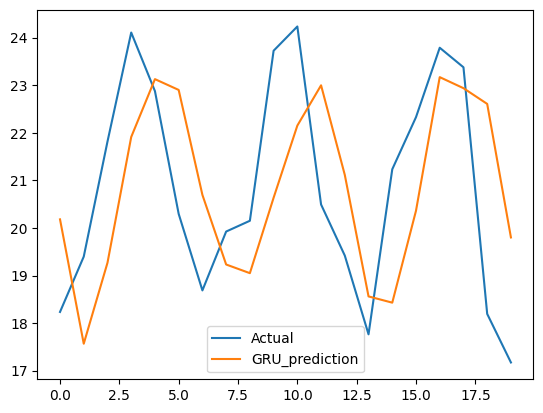

In [ ]:
plt.plot(time_series_data[180:], label = 'Actual')
plt.plot(GRU_preds, label = 'GRU_prediction')
plt.legend()
plt.show()

#Markowitz Model


In [ ]:
df

,삼성전자,SK하이닉스,POSCO홀딩스,현대차,기아,삼성SDI,현대모비스,LG,카카오,SK텔레콤,기업은행,S-Oil,KT
Date,,,,,,,,,,,,,
2000-01-04,6110,505462,142000,20700,7350,50400,6610,47025,30383,65564,5100,12725,169000
2000-01-18,6100,490740,145500,17800,7800,44300,6000,51188,26100,66426,5380,10500,139500
2000-02-01,5320,480925,129500,17000,6690,45700,6100,45852,24270,63235,5000,9750,124000
2000-02-16,5000,410259,100000,14000,6280,41550,5150,42217,43455,72465,4070,9950,123000
2000-03-02,5880,403388,110500,13200,4470,36150,4245,37174,32034,81955,3750,9225,107500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,57700,93500,239500,162500,66300,655000,199000,77300,48800,49550,10150,82200,36000
2022-11-08,61800,87700,273000,170000,67500,730000,217500,81800,51500,50500,10500,93900,36500
2022-11-22,60600,85200,292500,165500,65200,680000,210500,83600,54300,49750,11000,86900,36850


주가 정보의 데이터프레임을 이용하여 2000년 1월(0행)부터 2016년 2월(399행) 까지의 return 데이터프레임을 생성한다.

return은 '(전 시점의 주가 - 현 시점의 주가)/전 시점의 주가' 로 계산한다.
이때 초기(0행)의 return은 0이다.

In [ ]:
def return_mat(df, n):   # 주가 matrix를 return matrix로 변환

  new_df = {}
  for i in df.columns:
    new_df[i] = [0][:]

  new_df = pd.DataFrame(new_df)
  for i in range(1,n):
    X0 = df.iloc[i-1,:]
    X1= df.iloc[i,:]
    new_df.loc[i] = (X1-X0)/X0
  return new_df

return_matrix = return_mat(df.iloc[:400,:], 400)
return_matrix.index = df.index[0:400]
return_matrix

,삼성전자,SK하이닉스,POSCO홀딩스,현대차,기아,삼성SDI,현대모비스,LG,카카오,SK텔레콤,기업은행,S-Oil,KT
Date,,,,,,,,,,,,,
2000-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-18,-0.001637,-0.029126,0.024648,-0.140097,0.061224,-0.121032,-0.092284,0.088527,-0.140967,0.013147,0.054902,-0.174853,-0.174556
2000-02-01,-0.127869,-0.020000,-0.109966,-0.044944,-0.142308,0.031603,0.016667,-0.104243,-0.070115,-0.048038,-0.070632,-0.071429,-0.111111
2000-02-16,-0.060150,-0.146938,-0.227799,-0.176471,-0.061286,-0.090810,-0.155738,-0.079277,0.790482,0.145963,-0.186000,0.020513,-0.008065
2000-03-02,0.176000,-0.016748,0.105000,-0.057143,-0.288217,-0.129964,-0.175728,-0.119454,-0.262824,0.130960,-0.078624,-0.072864,-0.126016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-21,0.014263,-0.006515,-0.002950,0.009967,0.005566,0.012658,0.044025,0.015398,-0.054774,-0.023505,0.019157,0.024934,-0.017036
2016-01-07,-0.091406,-0.009836,-0.029586,-0.095395,-0.090406,-0.075000,-0.048193,-0.055101,0.045471,-0.107242,-0.101504,-0.034571,-0.038128
2016-01-21,-0.027515,-0.119205,-0.048780,-0.003636,-0.053753,-0.094595,0.012658,-0.020415,-0.053729,-0.053897,-0.100418,0.043767,-0.045045


현 시점을 2016년 2월 23일(399행)이라고 가정하자.

이 데이터프레임을 이용하여 다음 시점인 2016년 3월 9일(400행)의 Covariance Matrix와 return을 예측한다.

이때 Covariance Matrix는 390행부터 399행까지의 공분산 행렬을 이용하고, return은 길이가 5인 이동평균으로, 395행부터 399행까지의 평균을 사용하였다.

In [ ]:
Cov = matrix(np.array(return_matrix.iloc[max(0,len(return_matrix)-10):,:].cov()))
Mean = return_matrix.iloc[-5:].mean()

print(f'Covariance matrix : \n{Cov}')
print(f'Expected return of each asset : \n{Mean}')

Covariance matrix : 
[ 3.07e-03  1.21e-03  1.81e-03  1.92e-03  2.02e-03  1.37e-03  2.23e-03 ... ]
[ 1.21e-03  4.58e-03  3.36e-03  1.06e-03  3.31e-04  1.13e-03  5.68e-04 ... ]
[ 1.81e-03  3.36e-03  5.65e-03  1.55e-03  1.02e-03  7.49e-04  1.34e-03 ... ]
[ 1.92e-03  1.06e-03  1.55e-03  3.49e-03  3.18e-03  4.92e-04  1.75e-03 ... ]
[ 2.02e-03  3.31e-04  1.02e-03  3.18e-03  3.91e-03  9.64e-04  1.68e-03 ... ]
[ 1.37e-03  1.13e-03  7.49e-04  4.92e-04  9.64e-04  6.65e-03  9.51e-04 ... ]
[ 2.23e-03  5.68e-04  1.34e-03  1.75e-03  1.68e-03  9.51e-04  1.92e-03 ... ]
[ 1.32e-03  1.87e-04  1.99e-03 -2.73e-04  1.12e-04  2.93e-03  9.38e-04 ... ]
[-8.62e-04 -4.43e-05 -1.66e-03 -2.29e-03 -1.91e-03 -9.47e-04 -1.18e-03 ... ]
[ 1.03e-03  2.63e-03  4.13e-03  1.40e-03  7.73e-04  1.73e-03  6.09e-04 ... ]
[ 2.36e-03  2.28e-03  3.06e-03  2.10e-03  2.20e-03  2.34e-03  1.82e-03 ... ]
[ 1.10e-03  9.68e-04  2.30e-04 -4.92e-04 -1.24e-03  3.03e-03  6.06e-04 ... ]
[ 7.23e-04  1.70e-03  2.37e-03  1.92e-04 -7.29e-05  1.5

expected return, covariance를 이용하여 포트폴리오 최적화를 진행한다. 이를통해 최적의 포트폴리오 비중을 계산한다.

변수:

`weights` : 각 주식별 포트폴리오 비중의 벡터 [w1, w2, ...]

`initial_weight` : 최적화 진행 과정의 초기 해 벡터

`risk_free_rate` : 무위험 자산에 투자했을 때의 기대 수익률

`mean_returns` : 기대 수익률

`cov_matrix` : 공분산행렬

목적함수:

minimize -(∑(`weights`*`mean_returns`)-`risk_free_rate`)/(`weight.T`​·`cov_matrix`​·`weights`)^(1/2)

제약조건:

`weights_i` >= 0, ∀ i     (모든 주식에 대해 공매도를 진행하지 않는다.)

∑`weights` = 1            (포트폴리오 비중의 합은 1이다.)

In [ ]:
def calculate_portfolio_return(weights, mean_returns):
    return np.sum(weights * mean_returns)

def calculate_portfolio_risk(weights, cov_matrix):
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_stddev

def objective_function(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = calculate_portfolio_return(weights, mean_returns)
    portfolio_risk = calculate_portfolio_risk(weights, cov_matrix)
    return (portfolio_return - risk_free_rate) / portfolio_risk

initial_weights = [1/len(df.columns)] * len(df.columns)
risk_free_rate = 0


constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # 가중치의 합 = 1
    {'type': 'ineq', 'fun': lambda weights: weights}  # 비음조건
)
result = minimize(
    lambda weights: -objective_function(weights, Mean, Cov, risk_free_rate),
    initial_weights, method='SLSQP', constraints=constraints
)

ratio = result.x
portpolio_ratio_of_each_asset = pd.DataFrame(ratio, index = my_portfolio, columns = ['ratio'])
print(f'portfolio ratio of each stock : \n {portpolio_ratio_of_each_asset}')


portfolio ratio of each stock : 
                  ratio
삼성전자     -3.769811e-16
SK하이닉스   -4.603129e-17
POSCO홀딩스  4.492443e-01
현대차       1.763176e-16
기아       -3.478727e-16
삼성SDI    -5.402379e-16
현대모비스     3.310565e-01
LG        1.950632e-17
카카오       5.714205e-16
SK텔레콤    -5.390244e-16
기업은행     -9.160123e-16
S-Oil     2.196992e-01
KT        1.037297e-16


위에서 구한 주식별 비중을 통해 현 시점(2016-02-23)에 리벨런싱 할 주식의 개수를 구한다. 현 시점 가용 금액은 1천만원이고, 포트폴리오 비중과 현 시점의 주가를 고려한 주식의 개수를 계산한다.

밑의 예시에서는 포스코홀딩스 15주, 현대모비스 16주, S-Oil 25주를 현재의 포트폴리오로 한다.

In [ ]:
current_asset = 10000000
def invest_num(ratio, data, asset):  # 포트폴리오 비중, 자산 현황에 따른 주식 개수 반환
  ratio = [max(0, x) for x in ratio]
  num_of_stock=[]
  for i in range(len(ratio)):
    num_of_stock.append(asset*ratio[i]//data[i])
  return num_of_stock
num_of_stocks = invest_num(ratio, np.array(df.iloc[-1:,:])[0], current_asset)
number_of_each_stock = pd.DataFrame(num_of_stocks, index = my_portfolio, columns = ['Number of stock'])
print(f'number of stock by portfolio ratio : \n{number_of_each_stock}')

number of stock by portfolio ratio : 
          Number of stock
삼성전자                  0.0
SK하이닉스                0.0
POSCO홀딩스             15.0
현대차                   0.0
기아                    0.0
삼성SDI                 0.0
현대모비스                16.0
LG                    0.0
카카오                   0.0
SK텔레콤                 0.0
기업은행                  0.0
S-Oil                25.0
KT                    0.0


위 결과에 따라 포트폴리오 리밸런싱을 하고, 다음 시점인 2016년 3월 9일 주가변동에 따른 자산의 변화를 계산한다.

이 예시에서는 1000만원이 1017만6500원으로 변하였고, 이때의 수익률은 1.756% 이다.

In [ ]:
current_stock_price = df.iloc[399,:]
next_stock_price = df.iloc[400,:]

next_asset = current_asset
for i in range(len(df.columns)):

  next_asset = next_asset+ (next_stock_price[i]-current_stock_price[i])*num_of_stocks[i]
print(f'current asset : {current_asset}')
print(f'changed asset after 1 period : {next_asset}')
print(f'portfolio return during the period : {(next_asset-current_asset)/current_asset*100}%')

current asset : 10000000
changed asset after 1 period : 10176500.0
portfolio return during the period : 1.765%


같은 기간동안 모든 주식에 동일한 비중으로 투자했을 때의 결과(-1.33%)보다 더 좋은 결과가 나왔음을 확인

In [ ]:
actual_return = (current_stock_price-next_stock_price)/current_stock_price
print(f'actual return of each stock : \n{actual_return}')
print(f'mean of actual returns : \n{sum(actual_return)/len(actual_return)*100}%')

actual return of each stock : 
삼성전자       -0.011008
SK하이닉스     -0.004934
POSCO홀딩스   -0.069825
현대차        -0.003356
기아         -0.019792
삼성SDI      -0.033092
현대모비스       0.023211
LG          0.055178
카카오        -0.118249
SK텔레콤       0.061281
기업은행       -0.025424
S-Oil      -0.030788
KT          0.003466
dtype: float64
mean of actual returns : 
-1.3333237596424146%


# 포트폴리오 클래스 생성


return matrix를 구하는 과정부터 expected return을 구하고 최적화를 거쳐 자산의 변화를 거치는 과정을 반복하는 class를 생성한다.

이 class는 위에서 진행했던 현 시점의 포트폴리오를 설정하고 다음 시점의 자산의 변화를 확인하는 일련의 과정을 반복한다.

이때 expected return(`r_bar`)은 이동평균, ARIMA, XGBoost, GRU 중에 선택할 수 있다. ARIMA는 order (p, d, q)를 지정할 수 있고, XGBoost는 hyperparameter를 지정할 수 있다. GRU는 모델을 미리 설정하고 그 모델을 이용하여 예측한다.

In [ ]:
class Markowitz_model:
  def __init__(self, params):
    self.params = params
    try:
      if params['r_bar'] == 'XGB':
        self.XGB_params = hyperparameters = {
        'n_estimators': 50,
        'learning_rate': 0.1,
        'max_depth': 5,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0,
        'reg_lambda': 1}
      elif params['r_bar'] == 'ARIMA':
        self.order = (2,1,2)
    except: pass

  def invest_num(self, ratio, data, asset):  # 포트폴리오 비중, 자산 현황에 따른 주식 개수 반환
    ratio = [max(0, x) for x in ratio]
    num_of_stock=[]
    for i in range(len(ratio)):
      num_of_stock.append(asset*ratio[i]//data[i])
    return num_of_stock

  def return_mat(self, df, n):   # 주가 matrix를 return matrix로 변환
    df2 = df.copy(deep=True)
    new_df = {}
    for i in df.columns:
      new_df[i] = [0][:]

    new_df = pd.DataFrame(new_df)

    for i in range(1,n):
      X0 = df2.iloc[i-1,:]
      X1= df2.iloc[i,:]
      new_df.loc[i] = (X1-X0)/X0
    return new_df

##############################

  def arima(self, data):
    model = ARIMA(data, order = self.order)
    res = model.fit()
    return res.forecast(steps=1)

  def create_sequence(self, data, seq_length):
    sequence = [data.iloc[i:i+seq_length+1].tolist() for i in range(len(data)-seq_length+1+1)]

    # 시퀀스 데이터프레임 생성
    df = pd.DataFrame(sequence)

    return df

  def XGB_AR(self, data, seq_length):

    seq_df = pd.DataFrame(self.create_sequence(data, seq_length))

    X_train = seq_df.iloc[:-1,1:]
    y_train = seq_df.iloc[:-1,0]
    X_test = seq_df.iloc[-1:,1:]
    y_test = seq_df.iloc[-1:,0]

    model = xgb.XGBRegressor(**self.XGB_params)
    model.fit(X_train, y_train)
    pred_y = model.predict(X_test)
    return pred_y

  def create_sequence_for_GRU(self, data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length:i + seq_length + 1]
        sequences.append((seq, target))
    return np.array(sequences)

  def GRU(self, data, seq_length):

    sequences = self.create_sequence_for_GRU(data, seq_length)

    train_sequences = sequences[:-1]
    test_sequences = sequences[-1:]

    X_train = np.array([item[0] for item in train_sequences])
    y_train = np.array([item[1] for item in train_sequences])
    X_test = np.array([item[0] for item in test_sequences])
    y_test = np.array([item[1] for item in test_sequences])

    model = self.GRU_model
    model.fit(X_train, y_train,  epochs= 5, batch_size=8, verbose=0)
    pred_y = model.predict(X_test)
    return pred_y


  def get_mean(self, r_bar, return_data, n_columns, len_return):
    if r_bar == 'ARIMA':
      Mean = []
      for j in range (n_columns):
        Mean.append(float(self.arima(return_data.iloc[:,j])))
      Mean = matrix(Mean)
    elif r_bar[0:2] == 'MA':
      MA_len = int(r_bar[2:])
      if MA_len >= len(return_data):
        Mean = matrix(list(return_data.mean()*len_return/(len_return-1)))
      else:
        Mean = matrix(list(return_data.iloc[-MA_len:,:].mean()))
    elif r_bar == 'XGB':
      Mean = []
      for j in range (n_columns):
        Mean.append(float(self.XGB_AR(return_data.iloc[:,j], 5)))
      Mean = matrix(Mean)

    elif r_bar == 'GRU':
      Mean = []
      for j in range (n_columns):
        Mean.append(float(self.GRU(return_data.iloc[:,j], 5)))
      Mean = matrix(Mean)


    else:
      Mean = matrix(list(return_data.mean()*len_return/(len_return-1)))
    return Mean



#################################

  def Markowitz_max_sharp(self, df, r_bar, risk_free_rate, initial_invest, cov_len, start_point):

    asset = initial_invest
    asset_list = [asset]*(start_point-1)
    n_rows = len(df)    # number of rows
    columns = df.columns
    n_columns = len(columns)   # number of columns


    current_invest_num = [0]*n_columns
    return_df = self.return_mat(df, len(df))
    for i in range(start_point,n_rows):
      return_data = return_df.iloc[:i+1,:]
      data = df.iloc[:i+1,:]
      prior_stock_price=[]
      current_stock_price=[]


      for j in range(len(columns)):
        prior_stock_price.append(data.iloc[i-1,j])
        current_stock_price.append(data.iloc[i,j])

        asset = asset+ (current_stock_price[j]-prior_stock_price[j])*current_invest_num[j]  # 주가 변동에 따른 자산변화
      asset_list.append(asset)


      n = len(columns)
      len_return = len(return_data)

      Cov = matrix(np.array(return_data.iloc[max(0,len(return_data)-cov_len):-1,:].cov()))

      Mean = self.get_mean(r_bar, return_data, n_columns, len_return)

      def calculate_portfolio_return(weights, mean_returns):
          return np.sum(weights * mean_returns)

      def calculate_portfolio_risk(weights, cov_matrix):
          portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
          return portfolio_stddev

      def objective_function(weights, mean_returns, cov_matrix, risk_free_rate):
          portfolio_return = calculate_portfolio_return(weights, mean_returns)
          portfolio_risk = calculate_portfolio_risk(weights, cov_matrix)
          return (portfolio_return - risk_free_rate) / portfolio_risk

      initial_weights = [1/n_columns] * n_columns
      risk_free_rate = risk_free_rate


      constraints = (
          {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # 가중치의 합 = 1
          {'type': 'ineq', 'fun': lambda weights: weights}  # 비음조건
      )
      result = minimize(
          lambda weights: -objective_function(weights, Mean, Cov, risk_free_rate),
          initial_weights, method='SLSQP', constraints=constraints
      )

      ratio = result.x

      invest_num_data=[]
      for j in range(len(columns)):
        invest_num_data.append(data.iloc[i,j])
      current_invest_num = self.invest_num(ratio, invest_num_data, asset) # 주식 개수 업데이트
      print(f'{(i-start_point+1)/(n_rows-start_point)*100}%')
      clear_output(wait=True)


    for j in range(len(columns)):
      prior_stock_price.append(data.iloc[i-1,j])
      current_stock_price.append(data.iloc[i,j])

      asset = asset+ (current_stock_price[j]-prior_stock_price[j])*current_invest_num[j]
    asset_list.append(asset)

    return asset_list



  def simulate(self, df):

    params = {'r_bar' : 'MA5',
              'risk_free_rate' : 0.0025,
              'initial_invest' : 100000000,
              'cov_len' : 10,
              'start_point' : (int(len(df)*0.7)//1)}


    if self.params == None:
      pass
    else:
      params = {**params, **self.params}
    risk_free_rate = params['risk_free_rate']
    r_bar = params['r_bar']
    initial_invest = params['initial_invest']
    cov_len = params['cov_len']
    start_point = params['start_point']

    if params['r_bar'] == 'ARIMA':
      self.order = params['ARIMA_order']

    elif params['r_bar'] == 'XGB':
      self.XGB_params == params['XGB_params']

    elif params['r_bar'] == 'GRU':
      self.GRU_model = params['GRU_model']


    result = self.Markowitz_max_sharp(df, r_bar, risk_free_rate, initial_invest, cov_len, start_point)

    return result[start_point-1:]


# 모델 생성

model1은 기대 수익 예측에 ARIMA 모델을 사용한다. 여기서 사용하는 ARIMA 모델의 (p, d, q)의 값은 (2, 1, 2)이다.

`risk_free_rate`는 주식에 투자가 아닌 은행에 넣었을 때의 예상 수익률을 사용한다. 연간 시중금리를 3퍼센트로 가정하면 1 기간(10 영업일) 동안의 risk free rate는 약 0.125퍼센트 이다.

`cov_len`은 최적화 식의 공분산으로 사용할 값의 길이를 지정한다. `cov_len`을 10으로 설정하면 10 기간 동안의 공분산을 사용한다.

`start_point`는 투자를 시작하는 시점을 지정한다. 현재 데이터프레임에서의 `start_point`가 400일 경우, 2016년 2월 23일 부터 2022년 말까지 투자하는 것을 시뮬레이션한다.

In [ ]:
params1 = {'r_bar' : 'ARIMA',
           'ARIMA_order' : (2, 1, 2),
           'risk_free_rate' : 0.00125,
           'cov_len' : 10,
           'start_point' : 400}

model1 = Markowitz_model(params1)
result1 = model1.simulate(df[my_portfolio])

100.0%


model2는 model1과 다른 조건을 동일하게 지정하고, 기대수익의 예측값에 XGBoost를 사용한다. 이전 5 기간의 수익률을 각각의 feature로 지정하고, 자기회귀의 결과를 예측값 한다.

In [ ]:
XGB_parameters = {
    'n_estimators': 30,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0,
    'reg_lambda': 1}


params2 = {'r_bar' : 'XGB',
           'XGB_params' : XGB_parameters,
           'risk_free_rate' : 0.00125,
           'cov_len' : 10,
           'start_point' : 400
           }

model2 = Markowitz_model(params2)
result2 = model2.simulate(df[my_portfolio])

100.0%


model3는 기대수익의 예측값으로 순환신경망 모델인 GRU를 사용한다. 이때 input_shape를 (5, 1)로 지정하였다.

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense

GRU_model = Sequential()
GRU_model.add(GRU(8, input_shape=(5, 1)))
GRU_model.add(Dense(10))
GRU_model.add(Dense(1))
GRU_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

params3 = {'r_bar' : 'GRU',
           'GRU_model' : GRU_model,
           'risk_free_rate' : 0.00125,
           'cov_len' : 10,
           'start_point' : 400
           }

model3 = Markowitz_model(params3)
result3 = model3.simulate(df[my_portfolio])


1/1 [==============================] - 0s 21ms/step
100.0%


# Evaluation & Analysis
각 모델에서 포트폴리오의 수익률을 확인한다.
total return은 (마지막 시점의 자산 총량 - 첫 시점의 자산 총량)/첫 시점의 자상 총량의 퍼센트값으로 사용한다.
예를들어 초기 투자 금액이 1000원, 마지막 기간의 자산 총액이 2000원이면 수익률은 100%가 된다.

return의 예측값으로 ARIMA를 사용했을 때의 결과

총 수익률은 139.57퍼센트로, 2016년 2월 23일에 1억을 투자했을 경우 2022년 말에 약  2억3956만원이 된다.

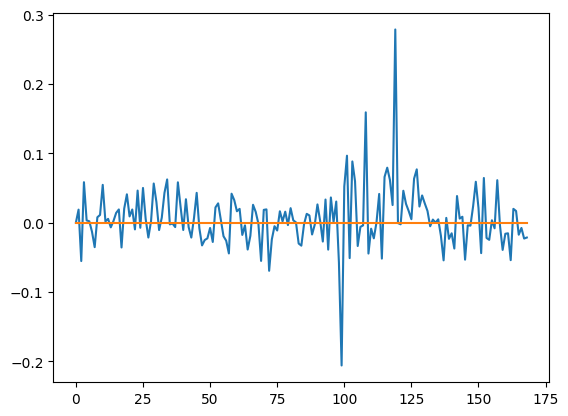

mean return by model1 = 0.6083371716915859%
risk by model1 = 4.299697951341498%
total return by model1 = 139.56971000000001%


In [ ]:
returns1 = get_returns(result1)
plt.plot(returns1)
plt.plot([0]*len(result1))
plt.show()
print(f'mean return by model1 = {sum(returns1)/len(returns1)*100}%')
print(f'risk by model1 = {get_risk(returns1)*100}%')
print(f'total return by model1 = {(result1[-1]-result1[0])/result1[0]*100}%')

XGBoost를 사용했을 때의 결과

총 수익률은 160.92퍼센트로, 2016년 2월 23일에 1억을 투자했을 경우 2022년 말에 약  2억6092만원이 된다.

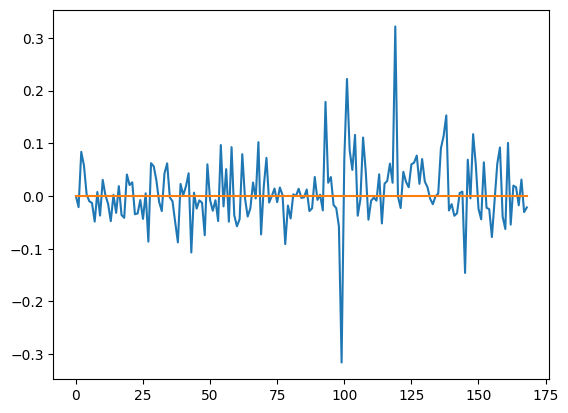

mean return by model2 = 0.765472062372036%
risk by model2 = 6.275083417237745%
total return by model2 = 160.92246%


In [ ]:
returns2 = get_returns(result2)
plt.plot(returns2)
plt.plot([0]*len(result2))
plt.show()
print(f'mean return by model2 = {sum(returns2)/len(returns2)*100}%')
print(f'risk by model2 = {get_risk(returns2)*100}%')
print(f'total return by model2 = {(result2[-1]-result2[0])/result2[0]*100}%')

GRU를 사용했을 때의 결과

총 수익률은 191.27퍼센트로, 2016년 2월 23일에 1억을 투자했을 경우 2022년 말에 약  2억9127만원이 된다.

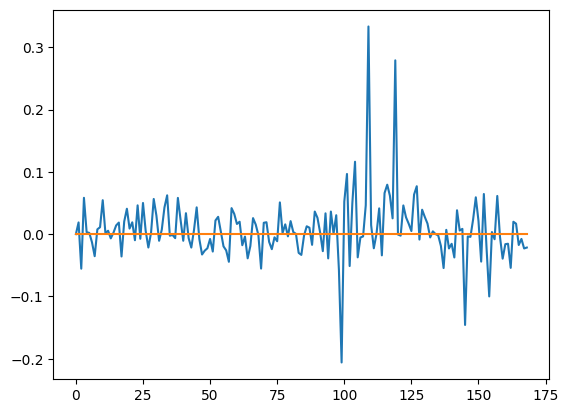

mean return by model3 = 0.7536618696510579%
risk by model3 = 5.014748899201975%
total return by model3 = 191.27198%


In [ ]:
returns3 = get_returns(result3)
plt.plot(returns3)
plt.plot([0]*len(result3))
plt.show()
print(f'mean return by model3 = {sum(returns3)/len(returns3)*100}%')
print(f'risk by model3 = {get_risk(returns3)*100}%')
print(f'total return by model3 = {(result3[-1]-result3[0])/result3[0]*100}%')

동일한 기간 동안 모든 주식에 동일한 비중으로 투자하고 유지했을 때의 결과이다. 총 수익률(91.978%)이 Markowitz 모델과 ARIMA, XGBoost, GRU 방법을 활용했을 때보다 낮게 나왔음을 확인할 수 있다.

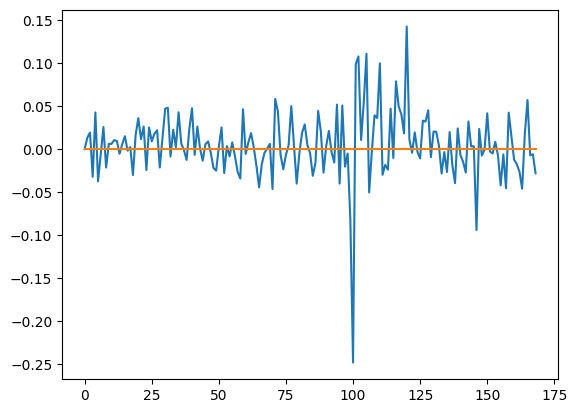

mean return by model4 = 0.46305023122021904%
risk by model4 = 3.8405269120152528%
total return by model4 = 91.97851409388578%


In [ ]:
return_df = return_mat(df,len(df))
returns4 = [0]
result4 = [100000000]
for i in range (400, len(df)):
  returns4.append(sum(return_df.iloc[i,:])/len(return_df.columns))
  result4.append(result4[i-400]*(1+returns4[i-399]))
plt.plot(returns4)
plt.plot([0]*len(returns4))
plt.show()
print(f'mean return by model4 = {sum(returns4)/len(returns4)*100}%')
print(f'risk by model4 = {get_risk(returns4)*100}%')
print(f'total return by model4 = {(result4[-1]-result4[0])/result4[0]*100}%')